### Load libaries

In [1]:
import tensorflow as tf
import hls4ml
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import json
%matplotlib inline

### Load the data and transform

In [2]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']
le = LabelEncoder()
y = le.fit_transform(y)
y = tf.keras.utils.to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

### Load the keras model

In [3]:
keras_model = tf.keras.models.load_model('keras_3layer.h5')
keras_model.summary()
# to retrain the model (not necessary):
#keras_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['acc'])
#keras_model.fit(X_train_val, y_train_val, 
#                validation_split = 0.25, epochs = 20, 
#                callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                                              patience=5, 
#                                                              restore_best_weights=True)])
#keras_model.save_model('keras_3layer.h5',save_format='h5', overwrite=True)
y_keras = keras_model.predict(X_test)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
fc1_relu (Dense)             (None, 64)                1088      
_________________________________________________________________
fc2_relu (Dense)             (None, 32)                2080      
_________________________________________________________________
fc3_relu (Dense)             (None, 32)                1056      
_________________________________________________________________
output_softmax (Dense)       (None, 5)                 165       
Total params: 4,389
Trainable params: 4,389
Non-trainable params: 0
_________________________________________________________________


### Create the hls4ml model and run C Simulation to get expected, quantized output

In [4]:
hls_cfg = hls4ml.utils.config_from_keras_model(keras_model, granularity='name')
hls_model = hls4ml.converters.convert_from_keras_model(keras_model, output_dir='my-hls-test', hls_config=hls_cfg)
hls_model.compile()
y_hls4ml = hls_model.predict(X_test)

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer
Layer name: fc1_relu, layer type: Dense
  -> Activation (relu), layer name: fc1_relu
Layer name: fc2_relu, layer type: Dense
  -> Activation (relu), layer name: fc2_relu
Layer name: fc3_relu, layer type: Dense
  -> Activation (relu), layer name: fc3_relu
Layer name: output_softmax, layer type: Dense
  -> Activation (softmax), layer name: output_softmax
Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, current shape: [[None, 16]]
Layer name: fc1_relu, layer type: Dense, current shape: [[None, 16]]
Layer name: fc2_relu, layer type: Dense, current shape: [[None, 64]]
Layer name: fc3_relu, layer type: Dense, current shape: [[None, 32]]
Layer name: output_softmax, layer type: Dense, current shape: [[None, 32]]
Creating HLS model
Writing HLS project
Done


### Check difference between hls4ml and keras

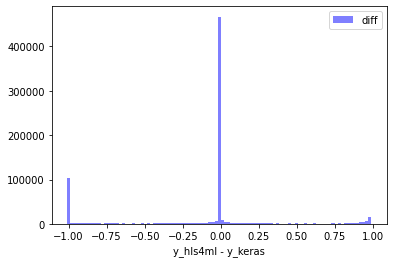

In [5]:
h, b = np.histogram((y_hls4ml - y_keras).flatten(), bins=np.linspace(-1,1,100))
plt.bar(b[:-1], h, width=b[1]-b[0], color='b', alpha=0.5, label='diff')
plt.legend()
plt.xlabel('y_hls4ml - y_keras')
plt.savefig('residual.png')

### Make ROC curves

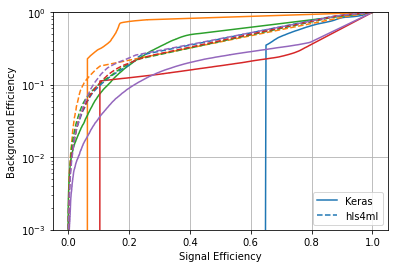

In [6]:
from sklearn.metrics import roc_curve
def roc(y_true, y, linestyle):
    for i in range(y_true.shape[1]):
        fpr, tpr, _ = roc_curve(y_true[:,i], y[:,i])
        plt.plot(tpr, fpr, linestyle=linestyle)
        
roc(y_test, y_keras, '-')
plt.gca().set_prop_cycle(None)
roc(y_test, y_hls4ml, '--')
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.ylim(0.001,1)
plt.grid(True)

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--')]
plt.legend(lines, ['Keras', 'hls4ml'])
plt.savefig('ROC.png')

### Run Synthesis, read resources

In [7]:
hls_model.build()
hls4ml.report.read_vivado_report('my-hls-test/')

Found 1 solution(s) in my-hls-test//myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
ERR: [SIM 100] CSim failed with errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Thu Jul  9 21:08:46 2020

* Version:        2019.2 (Build 2704478 on Wed Nov 06 22:10:23 MST 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: kintexu
* Target device:  xcku115-flvb2104-2-i


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 3.996 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+----------+----------+-----+-----+-